In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.linear_model import LinearRegression

In [17]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_polylines(paths_XYs, save_path=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4, 4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2, label=f'Polyline {i}')
    ax.set_aspect("equal")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, format='jpg')

    plt.show()

In [18]:
def adjust_control_points(points):
    if len(points) > 2:
        points[0] = 2 * points[1] - points[2]
        points[-1] = 2 * points[-2] - points[-3]
    return points

def generate_bezier_curve(points, s=0.8):
    points = adjust_control_points(points)
    tck, u = splprep([points[:, 0], points[:, 1]], s=s, k=3)
    unew = np.linspace(0, 1.0, 2000)
    out = splev(unew, tck)
    return out

def plot_bezier_curves(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            bezier_curve = generate_bezier_curve(XY)
            ax.plot(bezier_curve[0], bezier_curve[1], linewidth=2)
    ax.set_aspect("equal")
    plt.legend()
    plt.title('Bezier Curves')
    plt.show()

#### For open curves

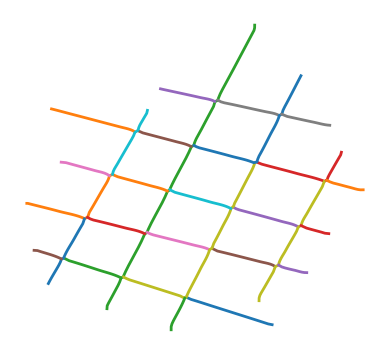

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


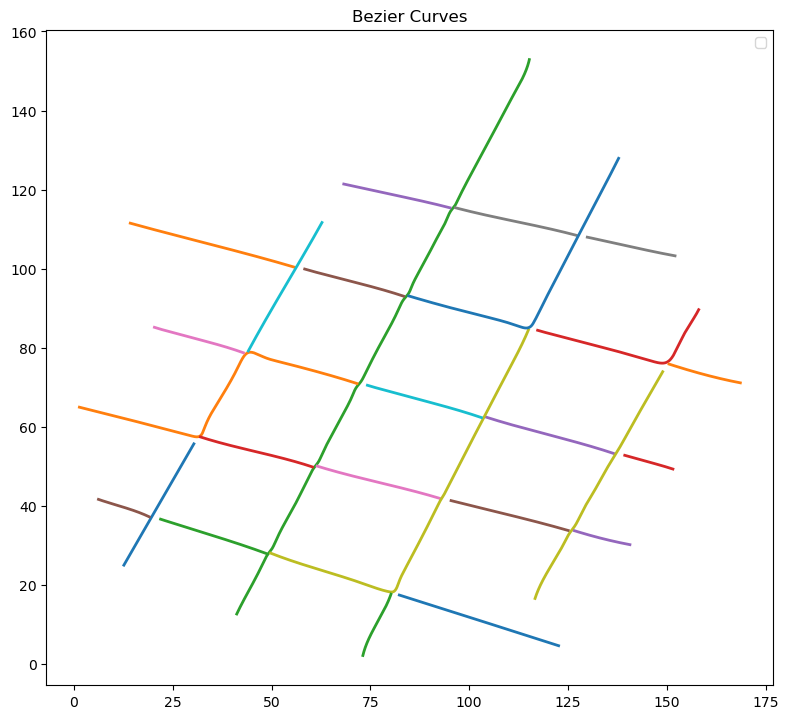

In [19]:
csv_path2 = "problems/frag2.csv"
paths2 = read_csv(csv_path2)
plot_polylines(paths2)
plot_bezier_curves(paths2)

#### For closed curves

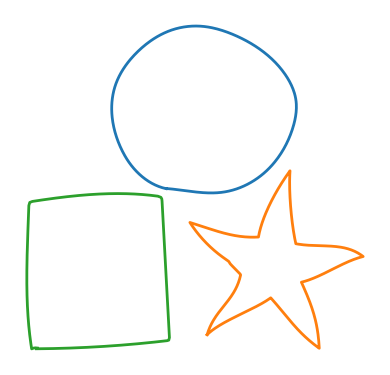

rectangle
rectangle
polygon
polygon
circle
circle


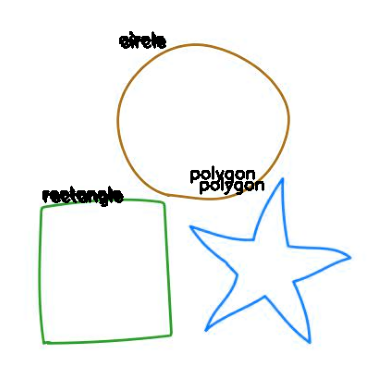

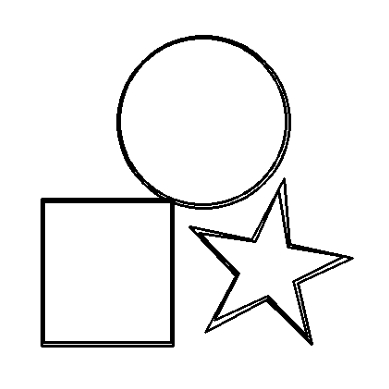

In [21]:
def getShapeName(approx):
    if len(approx) == 2:
        shape_name = "line"
    elif len(approx) == 3:
        shape_name = "triangle"
    elif len(approx) == 4 or len(approx) == 5:
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.95 <= aspect_ratio <= 1.05:
            shape_name = "square"
        else:
            shape_name = "rectangle"
    elif len(approx) > 12:
        shape_name = "circle"
    else:
        shape_name = "polygon"
    return shape_name

def fit_line(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    return slope, intercept

def draw_shape(image, shape_type, points):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, 0, 2)
    elif shape_type == "rectangle" or shape_type == "square":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, 0, 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, 0, 2)
    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=0, thickness=2)

def draw_fitted_line(image, slope, intercept, color):
    height, width, _ = image.shape
    x1, y1 = 0, int(intercept)
    x2, y2 = width, int(slope * width + intercept)
    cv2.line(image, (x1, y1), (x2, y2), color, 2)

def smooth_spline_curve(points, s=1.0):
    tck, u = splprep([points[:, 0], points[:, 1]], s=s)
    unew = np.linspace(0, 1, len(points))
    out = splev(unew, tck)
    return np.column_stack(out)

def smooth_curve(points, s=0.8):
    tck, u = splprep([points[:, 0], points[:, 1]], s=s, k=3)
    unew = np.linspace(0, 1.0, 200)
    out = splev(unew, tck)
    return np.column_stack(out).astype(np.int32)

# For using csv files
csv_path = "problems/isolated.csv"
paths = read_csv(csv_path)
plot_polylines(paths, 'frag0.jpg')

# For directly using jpg comment above 3 lines and add path here
img = cv2.imread('frag0.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

shape_image = np.ones_like(img) * 255
# plot_bezier_curves(contour)

for cont in contour:
    # print(cont)
    epsilon = 0.01 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    shape_name = getShapeName(approx)
    print(shape_name)

    x, y, w, h = cv2.boundingRect(approx) 
    cv2.putText(img, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    if shape_name == 'line':
        points = np.vstack([point[0] for point in approx])
        # Check if the line is almost straight
        if len(approx) == 2 or np.std(np.diff(points[:, 0])) < 2:
            slope, intercept = fit_line(points)
            draw_fitted_line(shape_image, slope, intercept, 0)
        else:
            smooth_curve = smooth_spline_curve(points)
            # smooth_curve = smooth_curve(cont)
            # cv2.polylines(shape_image, [smooth_curve], isClosed=False, color=(0, 0, 0), thickness=2)
            cv2.polylines(shape_image, [smooth_curve.astype(np.int32)], isClosed=False, color=0, thickness=2)
        # plot_bezier_curves(cont)
    elif shape_name == 'rectangle' or shape_name == 'square':
        draw_shape(shape_image, 'rectangle', approx)
    elif shape_name == 'circle':
        draw_shape(shape_image, 'circle', approx)
    elif shape_name == 'polygon':
        draw_shape(shape_image, 'polygon', approx)

plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(shape_image)
plt.axis('off')
plt.show()